In [24]:
#Modified to have functions for each stuff

# **Import Libraries**

In [1]:
import tkinter
from tkinter import *
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image, ImageTk
from tkinter import messagebox
from tkinter import ttk
from tkinter import Label, Entry, Button, Text, Tk, OptionMenu
import praw #Python Reddit API Wrapper
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import datetime as dt
import numpy as np
import seaborn as sns
import nltk #Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # Added for sentiment analysis
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Download NLTK stopwords and Vader Lexicon if not already downloaded
# nltk.download('stopwords')
# nltk.download('vader_lexicon')

# **Sentiment Analyzer**

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer # Added for sentiment analysis

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze the sentiment of a text using VADER
def perform_sentiment_analysis(data, threshold=0.3):
    sentiments = []

    for post in data.itertuples():
        text = post.title + " " + post.body

        # Perform sentiment analysis using VADER
        sentiment_scores = analyzer.polarity_scores(text)
        compound_score = sentiment_scores['compound']
        
        if compound_score >= threshold:
            sentiment_label = 'Positive'
        elif compound_score <= -threshold:
            sentiment_label = 'Negative'
        else:
            sentiment_label = 'Neutral'

        sentiments.append({
            "text": text,
            "sentiment": sentiment_label,
            "score": compound_score
        })

    return sentiments


# **Post Classification Fn**

In [3]:
def classify_post_media(post):
    if post.url.endswith(('.jpg', '.jpeg', '.png', '.gif')):
        return 'Image'
    elif 'v.redd.it' in post.url:
        return 'Video'
    else:
        return 'Text'

# Reddit Search Fn

In [37]:
from collections import Counter
from nltk.corpus import stopwords
import spacy
import string
from PIL import Image as PILImage
from IPython.display import Image, display

In [38]:
def reddit_search(subreddit_name):
    reddit = praw.Reddit(client_id='DP78tG9HeZiMQg', client_secret='xF80XIHboP51Lq63viNLTzxJrmE', user_agent='RedditWebScraping')
    subreddit = reddit.subreddit(subreddit_name)

    # Fetch hot posts
    hot_posts = subreddit.hot(limit=10000)

    # Store post data
    posts_data = []
    for post in hot_posts:
        posts_data.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
    
    posts_df = pd.DataFrame(posts_data, columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])
    return posts_df

In [39]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)

In [40]:
def plot_sentiment_pie(sentiments):
    sentiment_labels = [sentiment['sentiment'] for sentiment in sentiments]
    sentiment_counts = Counter(sentiment_labels)
    
    fig, ax = plt.subplots()
    ax.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    return fig

In [41]:
# # Define functions for generating plots
# def display_line_plot(posts_df, subreddit):
#     figure1 = plt.Figure(figsize=(4, 3), dpi=100)
#     ax1 = figure1.add_subplot(111)
#     line1 = FigureCanvasTkAgg(figure1, top)
#     line1.get_tk_widget().grid(row=1, column=3, columnspan=1, padx=5)
#     posts_df.plot(kind="line", x='title', y='num_comments', color='red', ax=ax1)
#     posts_df.plot(kind="line", x='title', y='interaction', color='blue', ax=ax1)
#     ax1.axes.get_xaxis().set_visible(False)
#     ax1.set_title('Timewise Presence Of Subreddit \''+subreddit+'\'', fontsize=10)

# def display_heatmap(posts_df, subreddit):
#     hm_selected_variables = posts_df[['timestamp', 'interaction', 'score', 'num_comments']]
#     figure2 = plt.Figure(figsize=(4, 3), dpi=100)
#     ax2 = figure2.add_subplot(111)
#     hm = FigureCanvasTkAgg(figure2, top) 
#     hm.get_tk_widget().grid(row=1, column=4, columnspan=1, padx=5)
#     correlation_matrix = hm_selected_variables.corr()
#     sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", ax=ax2, annot_kws={'fontsize': 6})
#     ax2.set_title('Correlation Heatmap Of Subreddit \''+Sub+'\'', fontsize=10)

# def display_media_distribution(media_counts):
#     figure3 = plt.Figure(figsize=(4, 3), dpi=100)
#     ax3 = figure3.add_subplot(111)
#     ax3_bar = FigureCanvasTkAgg(figure3, top)
#     ax3_bar.get_tk_widget().grid(row=2, column=3, columnspan=1, padx=5)
#     ax3.bar(media_counts.keys(), media_counts.values())
#     ax3.set_xlabel('Media Type')
#     ax3.set_ylabel('No. of Posts')
#     ax3.set_title('Distribution of Media Types')

# def display_grouped_bar_chart(grouped_data):
#     num_titles = len(grouped_data)
#     bar_width = 0.5
#     index = range(num_titles)

#     figure4 = plt.Figure(figsize=(4, 3), dpi=100)
#     ax4 = figure4.add_subplot(111)
#     ax4.bar(index, grouped_data['score'], bar_width, label='Score')
#     ax4.bar([i + bar_width for i in index], grouped_data['num_comments'], bar_width, label='Num Comments')
#     ax4.set_xlabel('Title')
#     ax4.set_ylabel('Value')
#     ax4.set_title('Comparison of Title, Score & No. of Comments')
#     ax4.legend()

In [42]:
def main(subreddit_name):
    posts_df = reddit_search(subreddit_name)
    posts_df['timestamp'] = posts_df["created"].apply(get_date)
    posts_df['interaction'] = posts_df['score'].divide(posts_df['num_comments'], fill_value=1)
    
    # Analyze sentiment
    sentiments = perform_sentiment_analysis(posts_df)
    
    # Plot sentiment pie chart
    sentiment_pie_fig = plot_sentiment_pie(sentiments)
    
#     # Display line plot
#     line_plot = display_line_plot(posts_df, posts_df)

#     # Display heatmap
#     heatmap = display_heatmap(posts_df, posts_df)

#     # Display media distribution plot
#     media_dis = display_media_distribution(media_counts)

#     # Display grouped bar chart
#     grp_bar = display_grouped_bar_chart(grouped_data)
    
    return posts_df, sentiment_pie_fig
#     return line_plot, heatmap, media_dis, grp_bar

In [43]:
def display_results(posts_df, sentiment_pie_fig):
    # Display posts data
    print(posts_df.head())

    # Display sentiment pie chart
    plt.show()

In [44]:

def on_search_button_click():
    subreddit_name = subreddit_entry.get()
    posts_df, sentiment_pie_fig = main(subreddit_name)
    display_results(posts_df, sentiment_pie_fig)

                                               title  score       id  \
0               Bitcoin Newcomers FAQ - Please read!    108  1bg5lv0   
1                   Daily Discussion, April 25, 2024     28  1cckljk   
2                                    Hate or love it    366  1ccpwui   
3  Buy Bitcoin sign guy sells his moment in Bitco...   1505  1ccflju   
4  Ron Paul defending Bitcoin at $500, exactly 10...     85  1ccqoev   

  subreddit                                                url  num_comments  \
0   Bitcoin  https://www.reddit.com/r/Bitcoin/comments/1bg5...            54   
1   Bitcoin  https://www.reddit.com/r/Bitcoin/comments/1cck...            84   
2   Bitcoin               https://i.redd.it/idnj4i8z5mwc1.jpeg            64   
3   Bitcoin                https://i.redd.it/3nilwnys3jwc1.png            87   
4   Bitcoin                    https://v.redd.it/8aoufielcmwc1            10   

                                                body       created  \
0  # Welcome to 

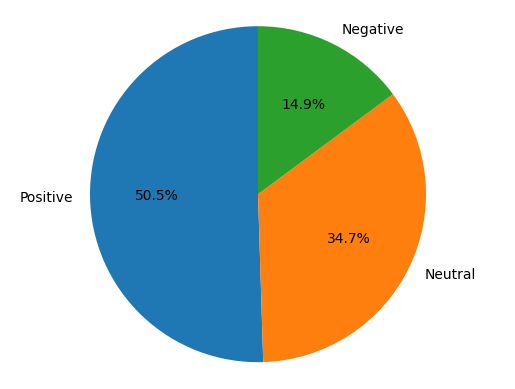

In [45]:
# GUI setup
root = tkinter.Tk()
root.title("Reddit Analysis")

# Create and place the elements in the grid
Label(root, text="Subreddit Name").grid(row=0, column=0, sticky="nsew")

subreddit_entry = Entry(root, bd=5)
subreddit_entry.grid(row=0, column=1)

search_button = Button(root, text="Search", command=on_search_button_click)
search_button.grid(row=0, column=2)

results_text = Text(root)
results_text.grid(row=1, column=0, columnspan=3)

root.mainloop()

['bitcoin', 'newcomers', 'faq', 'read']
['daily', 'discussion', 'april']
['purchased', 'bitcoin']
['bitcoin', '\u202f', 'etfs', 'saw', 'record', 'volume', 'billion', 'march', '\n\n', 'triple', 'inflows', 'february', ' ']
['✨', 'father', 'son', 'selling', 'family', 'porsche', 'bitcoin', 'exactly', 'years', 'ago']
['new', 'artwork', 'age', 'fiat', 'ii']
['ask', 'woman', 'age', 'man', 'salary', 'usa', 'happened']
['dad', 'told', 'saving', 'told', 'week', 'approx', '70k', 'damn', 'excited', 'april', 'fools', 'day', 'gave']
['bitcoin', 'lost']
['reminder', 'new', 'bitcoin', 'volatility']
['fast', 'forward']
['people', 'argue', 'craziest', 'stuff', '…', 'yea', 'shit', 'bitcoin', 'work', 'electricity', 'society', '…']
['bitcoin', 'demand', 'shock']
['know', 'voting']
['ledger', 'thing']
['recommendation', 'years', 'ago', 'going', 'cry']
['found', 'year', 'old', 'girl', 'book', 'stuff', 'bitcoin', 'home', '..', 'lol']
['bitcoin', 'falling', 'answer']
['bitcoin', 'boring']
['gilfoyle', 'explain

['understanding', 'federal', 'debt', 'deficit']
['sign']
['need', 'suggestions', 'short', 'compelling', 'bitcoin', 'videos']
['australian', 'crypto', 'tax', 'accountants']
['halving', 'near', 'germany']
['hi', 'guys', 'know', 'bitcoin', 'layer', 'lightning', 'network', 'mobile', 'wallet', 'app', 'good', 'daily', 'use', 'low', 'costs', 'transaction', 'stable', 'tia']
['find', 'previous', 'bitcoin', 'video']
['water', 'turbine', 'asic', 'miner']
['purchase', 'bitcoin']
['bitcoin', 'week']
['fed', 'trying', 'soft', 'landing']
['thoughts', 'dual', 'investments']
['discussing', 'inflation']
['going', 'easter', 'dinner']
['31,600']
['everybody', 'win']
['story', 'crypto', 'ray']
['millionaire', 'special', 'anymore', 'inflation']
['inflation', 'impacts', 'different', 'asset', 'classes', 'particularly', 'focusing', 'cryptocurrencies', 'bitcoin', 'monetary', 'policy', 'responses', 'influence', 'asset', 'prices']
['bitget', 'wallet', 'safe']
['understand', 'bitcoin', 'backed']
['bitcoin', 'tv', 

['wallet', 'activity', 'privacy', 'exposure', 'inactive', 'wallets']
['people', 'people', 'sell', 'big', 'chunks', 'bitcoin', 'outright', 'instead', 'borrowing']
['halving', 'compromise', 'network', 'security']
['travelling', 'year', 'having', 'constant', 'phone', 'number', 'exchanges']
['new', 'wallets']
['today', 'moved', 'bitcoin', 'exchange', 'feels', 'good']
['bitcoin', 'etf', 'blowout', 'wows', 'blackrock', 'larry', 'fink']
['let', 'honest']
['question', 'hopefully', 'answer', 'point', 'right', 'direction', '…']
['bitcoin', 'standard', 'change', 'way', 'build', 'bitcoin', 'commons', 'panel']
['symbol', 'merrill', 'bitcoin', 'spot', 'etf']
['bo', 'polny', 'predictions', 'dollar', 'collapse', 'april']
['cons', 'ln']
['crypto']
['stability', 'btc', 'mining', 'eco', 'system']
['practical', 'strategies', 'prevent', 'selling', 'bitcoin', 'years']
['daily', 'discussion', 'march']
['bitcoin', 'viewed', 'currency']
['chance', 'creating', 'identical', 'wallets']
['interview', 'debate', 'pr

['btc', 'passion', 'needs', 'satisfied']
['✨', 'tomorrow', 'ross', 'ulbricht', '40th', 'birthday', 'jail', 'serving', '2x', 'life', 'sentence', 'creating', '1st', 'major', 'bitcoin', 'marketplace', 'free', 'ross', '✊']
['bitcoin']
['question', 'realizing', 'bitcoin', 'block']
['bisq', 'easy', 'tutorial', 'global', 'free', 'bitcoin', 'trading', 'peer', 'peer', 'kyc', 'free', 'open', 'source', 'time', 'eu']
['going', 'forever', 'laura']
['vivek', '⚡', '️', '@vivek4real', 'x', '—', 'bitcoin', 'educational', 'video']
['bubbles']
['saylor', 'selling', 'mstr']
['cooperations', 'eventually', 'control', 'crypto', 'market', 'specifically', 'btc']
['mind', 'establish', 'solar', 'powered', 'bitcoin', 'mining', 'farm', 'india']
['crypto', 'tax', 'documents']
['battle', 'bitcoin', 'bitcoin', 'mechanic', '—', 'bitcoin']
['getting', 'rat', 'race']
['bisq', 'usa']
['looking', 'usb', 'home', 'miner', 'similar']
['bitcoin', 'failed', '…']
['maximalist', 'bitcoiner']
['bitcoin', 'optech', 'newsletter']
[

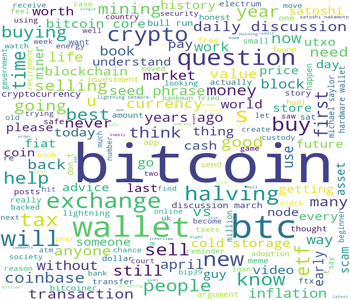

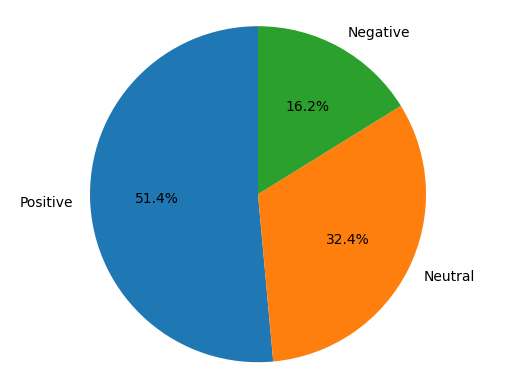

In [9]:
#####Original#####


# from collections import Counter
# from nltk.corpus import stopwords
# import spacy
# import string
# from PIL import Image as PILImage
# from IPython.display import Image, display


# # Define subreddit names
# subreddit_names = ['Bitcoin', 'Ethereum', 'Cryptocurrency', 'Cryptomarkets', 'Altcoin']

# def reddit_search(subreddit):
#     tb.delete('1.0', END)
#     flag = 0
#     test = ''
#     reddit = praw.Reddit(client_id='DP78tG9HeZiMQg', client_secret='xF80XIHboP51Lq63viNLTzxJrmE', user_agent='RedditWebScraping')
    
#     # Getting title from input
#     Sub = subreddit

#     tb.insert(INSERT, '\n------------------------------Subreddit-------------------------------------\n')
#     # Get 10000 hot posts from the given subreddit
#     hot_posts = reddit.subreddit(Sub).hot(limit=10000)
#     try:
#         for post in hot_posts:
#             tb.insert(INSERT, post.title)
#             tb.insert(INSERT, "\n")
#     except TclError:
#         pass

#     # Store the data from the posts
#     posts = []
#     this_subreddit = reddit.subreddit(Sub)
#     for post in this_subreddit.hot(limit=10000):
#         posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
#     posts = pd.DataFrame(posts, columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])
    
#     def get_date(created):
#         return dt.datetime.fromtimestamp(created)

#     try:
#         tb.insert(INSERT, posts)
#         _timestamp = posts["created"].apply(get_date)
#         posts = posts.assign(timestamp=_timestamp)
#         tb.insert(INSERT, posts[['title', 'score', 'timestamp']])
#         tb.insert(INSERT, "\n")
#         posts['interaction'] = posts['score'].divide(posts['num_comments'], fill_value=1)
#         tb.insert(INSERT, posts[['title', 'score', 'interaction']])
#         tb.insert(INSERT, "\n")
#     except TclError:
#         pass
    
#     # Text numerical analysis(new)
#     # Define the number of posts to process
#     limit_posts = 10000

#     # Initialize the Counter for word frequencies
#     word_counts = Counter()

#     # Load the English language model from spaCy
#     nlp = spacy.load("en_core_web_sm")

#     # Define a set of punctuation characters to be removed
#     punctuations = set(string.punctuation)
    
#     # Process the posts and update word counts
#     for post in this_subreddit.hot(limit=limit_posts):
#         title_words = nlp(post.title)
#         title_words = [word.text.lower() for word in title_words if not word.is_stop and word.text not in punctuations and "‘" not in word.text and "’" not in word.text and not word.text.isnumeric()]
#         word_counts.update(title_words)
#         print(title_words)

# ############
#     # Get the Media Types
#     # Collect data on the type of post media
#     media_types = []    
        
#     for post in this_subreddit.hot(limit=limit_posts):
#         media_type = classify_post_media(post)
#         media_types.append(media_type)
    
#     # Count the number of each media type
#     media_counts = Counter(media_types)

    
# ############
#     # Sort and display the most important topics
#     most_common_words = word_counts.most_common(20)

#     finalstr = "\n---------------Most Important Topics----------------------\n"
#     for word, count in most_common_words:
#         finalstr += f"{word}: {count}\n"
#         print(f"{word}: {count}")

#     # Insert the result into your text box 
#     tb.insert(INSERT, finalstr)
    
#     tb.insert(INSERT,'\n--------------------------------Graphs----------------------------------->\n')

# ############
#     # Line Plot
#     figure1 = plt.Figure(figsize=(4,3), dpi=100)
#     ax1 = figure1.add_subplot(111)
#     line1 = FigureCanvasTkAgg(figure1, top)
#     line1.get_tk_widget().grid(row=1,column=3,columnspan=1, padx=5)
#     posts.plot(kind="line",x='title',y='num_comments',color='red',ax=ax1)
#     posts.plot(kind="line",x='title',y='interaction',color='blue',ax=ax1)
#     ax1.axes.get_xaxis().set_visible(False)
#     ax1.set_title('Timewise Presence Of Subreddit \''+Sub+'\'', fontsize=10)
    
    
# ############
#     # Heat Map
#     # DataFrame with the selected variables
#     hm_selected_variables = posts[['timestamp', 'interaction', 'score', 'num_comments']]
    
#     figure2 = plt.Figure(figsize=(4,3), dpi=100)
#     ax2 = figure2.add_subplot(111)
#     hm = FigureCanvasTkAgg(figure2, top) 
#     hm.get_tk_widget().grid(row=1,column=4,columnspan=1, padx=5)
    
#     # Create a heatmap of the correlation between selected variables
#     correlation_matrix = hm_selected_variables.corr()
#     sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", ax=ax2, annot_kws={'fontsize': 6})
#     ax2.set_title('Correlation Heatmap Of Subreddit \''+Sub+'\'', fontsize=10)
    
    
# ############
#     # Media Types  
#     # Display the post media distribution plot in the tkinter window
#     figure3 = plt.Figure(figsize=(4, 3), dpi=100)
#     ax3 = figure3.add_subplot(111)
#     ax3_bar = FigureCanvasTkAgg(figure3, top)
#     ax3_bar.get_tk_widget().grid(row=2, column=3, columnspan=1, padx=5)
#     ax3.bar(media_counts.keys(), media_counts.values())
#     ax3.set_xlabel('Media Type')
#     ax3.set_ylabel('No. of Posts')
#     ax3.set_title('Distribution of Media Types')


# ############    
#     # Grouped bar chart
#     # DataFrame for the selected variables
#     gd_selected_variables = posts[['title', 'score', 'num_comments']]
    
#     # Group the data by 'title' and calculate the sum of 'score' and 'num_comments' for each title
#     grouped_data = gd_selected_variables.groupby('title').sum()
    
#      # Get the number of titles for the x-axis labels
#     num_titles = len(grouped_data)
    
#     # Set the width of each bar and the positions for each group
#     bar_width = 0.5
#     index = range(num_titles)

#     # Plot a grouped bar chart
#     figure4 = plt.Figure(figsize=(4, 3), dpi=100)
#     ax4 = figure4.add_subplot(111)
#     ax4.bar(index, grouped_data['score'], bar_width, label='Score')
#     ax4.bar([i + bar_width for i in index], grouped_data['num_comments'], bar_width, label='Num Comments')
#     ax4.set_xlabel('Title')
#     ax4.set_ylabel('Value')
#     ax4.set_title('Comparison of Title,Score & No. of Comments')
# #     ax4.set_xticklabels([''] * num_titles)  # Set empty labels for the titles
#     ax4.legend()
#     chart = FigureCanvasTkAgg(figure4, top)
#     chart.get_tk_widget().grid(row=2, column=4, columnspan=1, padx=5)
    

# ############    
#     tb.insert(INSERT, '\n------------------ Sentiment Analysis ------------------↓\n\n')
    
#     # Perform sentiment analysis
#     sentiments = perform_sentiment_analysis(posts)
    
#     # Pie chart for sentiment analysis results
#     sentiment_labels = [sentiment['sentiment'] for sentiment in sentiments]
#     sentiment_counts = Counter(sentiment_labels)
    
#      # Perform sentiment analysis
#     sentiments = perform_sentiment_analysis(posts)
    
#     # Extract positive, negative, and neutral words from the sentiment analysis results
#     positive_words = []
#     negative_words = []
#     neutral_words = []
    
#     for sentiment in sentiments:
#         if sentiment['sentiment'] == 'Positive':
#             words = nlp(sentiment['text'])
#             for word in words:
#                 if not word.is_stop and word.text not in punctuations and not word.text.isnumeric():
#                     positive_words.append(word.text)
#         elif sentiment['sentiment'] == 'Negative':
#             words = nlp(sentiment['text'])
#             for word in words:
#                 if not word.is_stop and word.text not in punctuations and not word.text.isnumeric():
#                     negative_words.append(word.text)
#         else:
#             words = nlp(sentiment['text'])
#             for word in words:
#                 if not word.is_stop and word.text not in punctuations and not word.text.isnumeric():
#                     neutral_words.append(word.text)
    
    
#     # Display the 20 most common positive, negative, and neutral words
#     tb.insert(INSERT, '------ Positive Words ------\n')
#     tb.insert(INSERT, ', '.join(positive_words[:20]) + '\n\n')
    
#     tb.insert(INSERT, '------ Negative Words ------\n')
#     tb.insert(INSERT, ', '.join(negative_words[:20]) + '\n\n')
    
#     tb.insert(INSERT, '------ Neutral Words ------\n')
#     tb.insert(INSERT, ', '.join(neutral_words[:20]) + '\n\n')

    
#     fig, ax = plt.subplots()
#     ax.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', startangle=90)
#     ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
#     # Create a FigureCanvasTkAgg to display the pie chart in the GUI
#     canvas = FigureCanvasTkAgg(fig, master=top)
#     canvas.get_tk_widget().grid(row=2, column=0, columnspan=3)
    

# ############
#     # WordCloud
#     dataset = str(posts.title.values)
#     wordCloudDf = pd.DataFrame(posts,columns=['title'])

#     comment_words = ''
#     stopstop = set(STOPWORDS) 

#     #iterate through the csv file 
#     for val in wordCloudDf.title: 

#      # typecaste each val to string 
#         val = str(val) 

#      # split the value 
#         tokens = val.split() 

#      # Converts each token into lowercase 
#         for i in range(len(tokens)): 
#             tokens[i] = tokens[i].lower() 

#         comment_words += " ".join(tokens)+" "
    
#     # Generate the WordCloud and save it to a file
#     wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopstop, min_font_size = 10).generate(comment_words) 
#     wordcloud.to_file("wordCloud.png") 
    
#     # Resize the WordCloud image using Pillow
#     img = PILImage.open("wordCloud.png")
#     img = img.resize((350, 300), PILImage.BICUBIC)
#     img.save("wordCloud_resized.png")

#     # Display the resized WordCloud in the Jupyter Notebook
#     display(Image(filename="wordCloud_resized.png"))    

    
# top = tkinter.Tk()
# top.tk.call('encoding', 'system', 'utf-8')
# top.wm_title("Reddit Analysis")

# # Create and place the elements in the grid
# Label(top, text="Select Subreddit:").grid(row=0, column=0, sticky="nsew")

# # Create the dropdown menu for subreddit selection
# selected_subreddit = tkinter.StringVar(top)
# selected_subreddit.set(subreddit_names[0])  # Set default value

# # Dropdown menu
# subreddit_dropdown = OptionMenu(top, selected_subreddit, *subreddit_names)
# subreddit_dropdown.grid(row=0, column=1)

# B = Button(top, text="Search", command=lambda: reddit_search(selected_subreddit.get()))
# B.grid(row=0, column=2)

# tb = Text(top)
# tb.grid(row=1, column=0, columnspan=3)

# top.mainloop()